In [1]:
import datetime
import logging

import dateutil.parser
import requests
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline

# replace default logging
del logging.root.handlers[0]
logging.basicConfig(level=logging.INFO)

/Users/fedor/.virtualenvs/py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
query = """
SELECT ?item ?itemLabel ?_image ?_inception ?_creator ?_creatorLabel WHERE {
  # select all paintings
  ?item wdt:P31 wd:Q3305213.
  # made with oil
  ?item wdt:P186 wd:Q296955.
  # written in english
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  # store the image
  OPTIONAL { ?item wdt:P18 ?_image. }
  # store the creation date
  OPTIONAL { ?item wdt:P571 ?_inception. }
  # store the creator
  OPTIONAL { ?item wdt:P170 ?_creator. }
}
"""

In [3]:
url = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"
resp = requests.get(url, 
                    params=dict(query=query), 
                    headers={'Accept': 'application/json'})

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): query.wikidata.org


In [4]:
data = resp.json()

In [5]:
for row in data['results']['bindings']:
    if '_inception' in row and row['_inception']['type'] == 'literal':
        try:
            date = row['_inception']['value']
            row['date'] = dateutil.parser.parse(date)
        except ValueError as e:
            logging.info("not parsed %s\n%s", date, row)
            

In [6]:
# analyze all data
dates = []
for row in data['results']['bindings']:
    if 'date' in row:
        dates.append(
            matplotlib.dates.date2num(row['date'])
        )

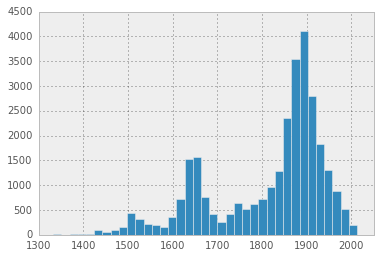

In [7]:
fig, ax = plt.subplots()
_ = ax.hist(dates, bins=100)
ax.set_xlim(matplotlib.dates.date2num(datetime.datetime(1300, 1, 1)),
            matplotlib.dates.date2num(datetime.datetime(2050, 1, 1)))
ax.xaxis_date(tz=dateutil.tz.tzutc())
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(100))


In [8]:
row

{'_creator': {'type': 'uri',
  'value': 'http://www.wikidata.org/entity/Q1392811'},
 '_creatorLabel': {'type': 'literal',
  'value': 'Joaquim Sunyer',
  'xml:lang': 'en'},
 '_inception': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
  'type': 'literal',
  'value': '1929-01-01T00:00:00Z'},
 'date': datetime.datetime(1929, 1, 1, 0, 0, tzinfo=tzutc()),
 'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q24195304'},
 'itemLabel': {'type': 'literal', 'value': 'Q24195304'}}

In [9]:
import pydash

In [25]:
rows = []
for row in data['results']['bindings']:
    creator = pydash.get(row, '_creatorLabel.value')
    name = pydash.get(row, 'itemLabel.value')

    datestr = pydash.get(row, '_inception.value')
    datetype = pydash.get(row, '_inception.type')
    img = pydash.get(row, '_image.value')
    if datestr and datetype == 'literal':
        try:
            date = dateutil.parser.parse(datestr)
        except:
            logging.exception("error %s\n%s", datestr, row)
    else:
        date = None
    rows.append(
        dict(
            creator=creator,
            name=name,
            date=date,
            img=img
        )
    )

In [78]:
import pandas
df = pandas.DataFrame(data=rows)
df.ix[df.creator == 'anonymous'] = None
# drop missings and duplicates
df = df.dropna().drop_duplicates()
len(df)

17689

In [79]:
table = pandas.crosstab(df.creator, columns=['creator'])
table.sort_values(['creator'], ascending=False).head()

col_0,creator
creator,
Rembrandt,613
Camille Pissarro,407
Vincent van Gogh,330
Albert Bierstadt,309
Jacob van Ruisdael,301


In [114]:
template = """
<style>

.paintings {
  display: flex;
  flex-flow: row wrap;

}
.painting img {
  max-width: 50px;
  max-height: 50px;
}
</style>
<div class="paintings">
% for i, row in table:
<div class="painting">
<img src="${row.img}" /> 
</div>
% endfor
</div>
"""
import mako.template
T = mako.template.Template(template)

In [119]:
import IPython.display
IPython.display.HTML(T.render(table=df.head(n=80).iterrows()))

In [96]:
for row in df.head():
    row
row

'name'

In [136]:
df.ix[317].img,  df.ix[318].img

('http://commons.wikimedia.org/wiki/Special:FilePath/Tizian%20018.jpg',
 'http://commons.wikimedia.org/wiki/Special:FilePath/Tiziano%2C%20madonna%20del%20coniglio%2C%201525-30%20ca.%2002.JPG')